In [2]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import shutil

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.gland import gland_data

%matplotlib inline

## Configurations

In [20]:
config = gland_data.GlandConfig()
config.display()
# BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/balloon")
DATASET_DIR = '/home/mkubita/Pulpit/projektBadawczy/Dataset_Model/'
config.USE_MINI_MASK = False


Configurations:
BACKBONE                       alexnet
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [42]:
# Config for resnet50
config_2 = config
config_2.BACKBONE = 'resnet101'
config_2.display()
# config.MASK_SHAPE = [56, 56]


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

config.display()


Configurations:
BACKBONE                       alexnet
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [11]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [12]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [17]:
# Load dataset
dataset1 = gland_data.GlandDataset()
dataset1.load_gland(DATASET_DIR, "val")

dataset2 = gland_data.GlandDataset()
dataset2.load_gland(DATASET_DIR, "val2")

# Must call before using the dataset
dataset1.prepare()
dataset2.prepare()

print("Image Count: {}".format(len(dataset1.image_ids)))
print("Class Count: {}".format(dataset1.num_classes))
for i, info in enumerate(dataset1.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
    
print("Image Count: {}".format(len(dataset2.image_ids)))
print("Class Count: {}".format(dataset2.num_classes))
for i, info in enumerate(dataset2.class_info):
    print("{:3}. {:50}".format(i, info['name']))

image_ids1 = dataset1.image_ids
image_ids2 = dataset2.image_ids

Image Count: 56
Class Count: 2
  0. BG                                                
  1. gland                                             
Image Count: 18
Class Count: 2
  0. BG                                                
  1. gland                                             


In [43]:
model_path_resnet101 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Augmentation/Resnet101_28_28/mask_rcnn_gland_0030(10).h5'
model = modellib.MaskRCNN(mode="inference", model_dir=model_path_resnet101, config=config_2)
model.load_weights(model_path_resnet101, by_name=True)

In [21]:
model_path_alexnet = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/NoAugumentation/Alexnet_56/mask_rcnn_gland_0030(9).h5'
model = modellib.MaskRCNN(mode="inference", model_dir=model_path_alexnet, config=config)
model.load_weights(model_path_alexnet, by_name=True)

In [29]:
model_path_resnet = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/NoAugumentation/Resnet50_56_56/mask_rcnn_gland_0030(14).h5'
model = modellib.MaskRCNN(mode="inference", model_dir=model_path_resnet, config=config_2)
model.load_weights(model_path_resnet, by_name=True)

## Load Models

In [8]:
# Load models
# model 1 - Resnet 101
# model 2 - Resnet 101 + data_augmnetation
# model 3 - Resnet 50 + data_augmentation


models_paths = ['/home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet101/mask_rcnn_gland_0030.h5',
                '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet101_data_augm/mask_rcnn_gland_0030.h5']
model_path_resnet50 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet50_data_agu/gland20220507T1203/mask_rcnn_gland_0025.h5'

models = [modellib.MaskRCNN(mode="inference", model_dir=model_path, config=config) for model_path in models_paths]
models_paths.append(model_path_resnet50)

models.append(modellib.MaskRCNN(mode="inference", model_dir=model_path_resnet50, config=config_2))

# Load weights
for model, model_path in zip(models, models_paths):
    print("Loading weights ", model_path)
    model.load_weights(model_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-05-16 18:27:42.092073: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-16 18:27:43.565180: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-16 18:27:43.565213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (k-mkubita01): /proc/driver/nvidia/version does not exist


Loading weights  /home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet101/mask_rcnn_gland_0030.h5


2022-05-16 18:27:52.864917: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-16 18:27:52.894437: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2022-05-16 18:27:52.895065: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe304000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-16 18:27:52.895090: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Loading weights  /home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet101_data_augm/mask_rcnn_gland_0030.h5
Loading weights  /home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet50_data_agu/gland20220507T1203/mask_rcnn_gland_0025.h5
Re-starting from epoch 25


image ID: gland.testA_46.bmp (41) /home/mkubita/Pulpit/projektBadawczy/Dataset_Model/val/testA_46.bmp
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


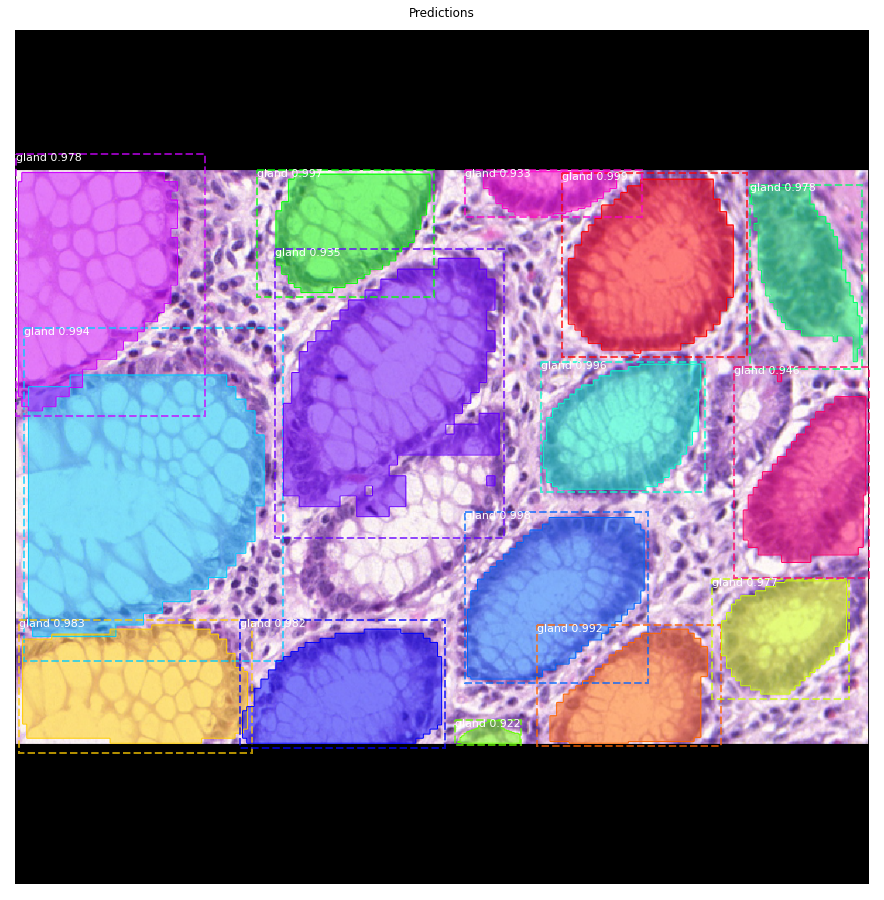

In [17]:
image_id = random.choice(dataset.image_ids)
config.USE_MINI_MASK = False

# test for testA_52, tetsA_9
# for model in model:
    
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

image ID: gland.testB_10.bmp (8) /home/mkubita/Pulpit/projektBadawczy/Dataset_Model/val2/testB_10.bmp
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


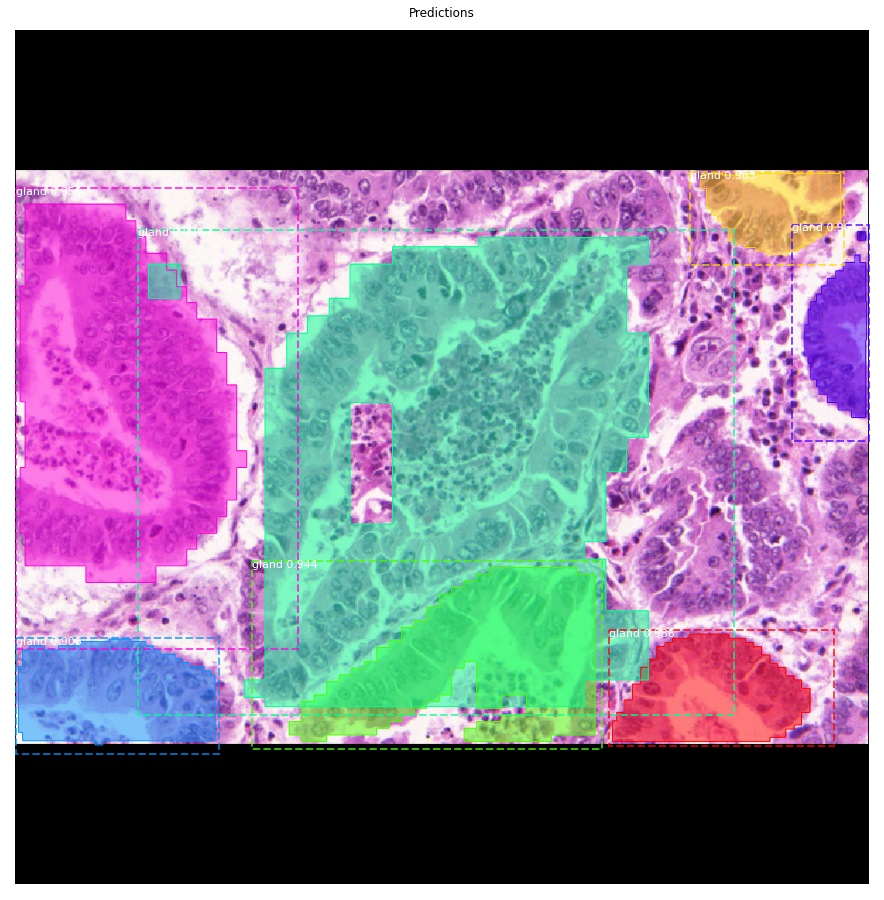

In [28]:
image_id = random.choice(dataset2.image_ids)
config.USE_MINI_MASK = False

# test for testA_52, tetsA_9
# for model in model:
    
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset2, config, image_id)

info = dataset2.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset2.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset2.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [14]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids, model, dataset):
    APs = []
    for image_id in image_ids:
        try:
            # Load image
            image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset, config,
                                       image_id)
            # Run object detection
            results = model.detect([image], verbose=0)
            # Compute AP
            r = results[0]
            AP, precisions, recalls, overlaps =\
                utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                  r['rois'], r['class_ids'], r['scores'], r['masks'])
            APs.append(AP)
        except:
            pass
    return APs

# Pick a set of random images
# image_ids = np.random.choice(dataset.image_ids, 20)
# for all test images
# APs = [compute_batch_ap(image_ids, model) for model in models]

# calculate IoU for all images
def compute_batch_iou(image_ids, model, data_set):
    Iou = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(data_set, config,
                                   image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute IoU
        r = results[0]
        iou_score = compute_iou(r['masks'], gt_mask)
        Iou.append(iou_score)
    return Iou

def compute_dice_metric(iou):
    return 2 * iou/ (iou + 1)

def compute_iou(predict_mask, gt_mask):
    """
    Computes Intersection over Union score for two binary masks.
    :param predict_mask: numpy array
    :param gt_mask: numpy array
    :type1 and type2 results are same
    :return iou score:
    """
    if predict_mask.shape[2]==0:
        return 0
    mask1 = merged_mask(predict_mask)
    mask2 = merged_mask(gt_mask)
    
    #type 1
    intersection = np.sum((mask1 + mask2) > 1)
    union = np.sum((mask1 + mask2) > 0)
    iou_score = intersection / float(union)
    #print("Iou 1 : ",iou_score)
    
    #type2
    intersection = np.logical_and(mask1, mask2)#*
    union = np.logical_or(mask1, mask2)# +
    iou_score = np.sum(intersection) / np.sum(union)
    #print("Iou 2 : ",iou_score)
    return iou_score

def merged_mask(masks):
    """
    merge mask into one and return merged mask
    """
    n= masks.shape[2]
    
    if n!=0:        
        merged_mask = np.zeros((masks.shape[0], masks.shape[1]))
        for i in range(n):
            merged_mask+=masks[...,i]
        merged_mask=np.asarray(merged_mask,dtype=np.uint8)   
        return merged_mask
    return masks[:,:,0]


# for ap in APs:
#     print("mAP @ IoU=50: ", round(np.mean(ap)*100, 2))

# resnet101_mAP = compute_batch_ap(image_ids, model)
# mAP = round(np.mean(resnet101_mAP), 3)

In [21]:
mAP

0.496

In [44]:
config.USE_MINI_MASK = False
resnet101_mAP1 = compute_batch_ap(image_ids1, model, dataset1)
resnet101_mAP2 = compute_batch_ap(image_ids2, model, dataset2)

mAP1 = round(np.mean(resnet101_mAP1), 3)
mAP2 = round(np.mean(resnet101_mAP2), 3)
mAP1, mAP2

(0.0, 0.0)

In [46]:
Iou_Resnet101_1 = compute_batch_iou(image_ids1, model, dataset1)
Iou_Resnet101_2 = compute_batch_iou(image_ids2, model, dataset2)

In [47]:
iou1 = round(np.mean(Iou_Resnet101_1),3)
iou2 = round(np.mean(Iou_Resnet101_2),3)
iou1, iou2


(0.0, 0.0)

In [48]:
dice_1 = round(compute_dice_metric(iou1), 3)
dice_2 = round(compute_dice_metric(iou2), 3)

dice_1, dice_2

(0.0, 0.0)

In [61]:
import pandas as pd

In [68]:
# Resnet101 comparison
metrics = {'Models': ['Resnet101_56', 'Resnet50_56', 'Alexnet_84'],
            'mAP_Dataset1': mAP1,
            'mAP_Dataset2': mAP2,
            'Jaccard_Dataset1': jac1,
            'Jaccard_Dataset2': jac2,
            'Dice_Dataset1': dice1,
            'Dice_Dataset2': dice2,

          }

df = pd.DataFrame(metrics)
df

,Models,mAP_Dataset1,mAP_Dataset2,Jaccard_Dataset1,Jaccard_Dataset2,Dice_Dataset1,Dice_Dataset2
0,Resnet101_56,0.496,0.541,0.502,0.568,0.668,0.724
1,Resnet50_56,0.628,0.673,0.624,0.598,0.768,0.748
2,Alexnet_84,0.385,0.402,0.388,0.329,0.559,0.495


In [67]:
mAP1 = [0.496, 0.628, 0.385]
mAP2 = [0.541, 0.673, 0.402]
jac1 = [0.502, 0.624, 0.388]
jac2 = [0.568, 0.598, 0.329]
dice1 = [0.668, 0.768, 0.559]
dice2 = [0.724, 0.748, 0.495]

In [39]:
# NO Augmnetation

mAP1 = [0.482, 0.042, 0.403]
mAP2 = [0.335, 0.023, 0.312]
jac1 = [0.480, 0.067, 0.387]
jac2 = [0.478, 0.061, 0.277]
dice1 = [0.649, 0.126, 0.558]
dice2 = [0.647, 0.115, 0.434]

In [41]:
import pandas as pd
metrics = {'Models': ['Resnet101_56', 'Resnet50_56', 'Alexnet_84'],
            'mAP_Dataset1': mAP1,
            'mAP_Dataset2': mAP2,
            'Jaccard_Dataset1': jac1,
            'Jaccard_Dataset2': jac2,
            'Dice_Dataset1': dice1,
            'Dice_Dataset2': dice2,

          }

df = pd.DataFrame(metrics)
df

,Models,mAP_Dataset1,mAP_Dataset2,Jaccard_Dataset1,Jaccard_Dataset2,Dice_Dataset1,Dice_Dataset2
0,Resnet101_56,0.482,0.335,0.480,0.478,0.649,0.647
1,Resnet50_56,0.042,0.023,0.067,0.061,0.126,0.115
2,Alexnet_84,0.403,0.312,0.387,0.277,0.558,0.434
